now only fish/engine

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Paths
data_folder = "./time_sets_standardized"

# Function to load and process individual vessel data
def load_and_process_vessel_data(folder_path):
    data, labels = [], []
    status_counts = {}

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                continue  # Skip files with missing or invalid data

            # Extract the time series features
            sog = df["SOG"].values
            cog = df["COG"].values
            heading = df["Heading"].values

            # Subtract the initial COG
            initial_cog = cog[0]
            cog = cog - initial_cog
            heading = heading - initial_cog

            # Normalize angles to the range [0, 360) after subtraction
            cog = np.mod(cog, 360)
            heading = np.mod(heading, 360)

            # Cyclical encoding for COG and Heading
            cog_sin = np.sin(np.radians(cog))
            cog_cos = np.cos(np.radians(cog))
            heading_sin = np.sin(np.radians(heading))
            heading_cos = np.cos(np.radians(heading))

            # Combine time series features into a single array
            combined_features = np.stack([sog, cog_sin, cog_cos, heading_sin, heading_cos], axis=1)

            # Extract label
            label = df["Navigational status"].iloc[0]
            if label in ["Under way using engine", "Engaged in fishing"]:
                data.append(combined_features)
                labels.append(label)

                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

    return np.array(data), np.array(labels), status_counts

# Load and preprocess data
data, labels, status_counts = load_and_process_vessel_data(data_folder)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Print class distribution
print("Class distribution:", dict(zip(label_encoder.classes_, np.bincount(labels))))

# Pad sequences to ensure consistent length
max_length = max(len(row) for row in data)
data = np.array([np.pad(row, ((0, max_length - len(row)), (0, 0)), mode='constant') for row in data])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to balance the classes
def undersample_data(X, y):
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    class_1_undersampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)
    
    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))
    
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced.reshape(-1, X_train_balanced.shape[-1])).reshape(X_train_balanced.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Convert labels to categorical
y_train_balanced = to_categorical(y_train_balanced)
y_test = to_categorical(y_test)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_balanced.shape[1], X_train_balanced.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_balanced, y_train_balanced, epochs=500, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Class distribution: {'Engaged in fishing': 4429, 'Under way using engine': 7944}
Epoch 1/500
220/220 [==============================] - 7s 15ms/step - loss: 0.5195 - accuracy: 0.7413 - val_loss: 0.4748 - val_accuracy: 0.7644
Epoch 2/500
220/220 [==============================] - 2s 11ms/step - loss: 0.4804 - accuracy: 0.7702 - val_loss: 0.4771 - val_accuracy: 0.7564
Epoch 3/500
220/220 [==============================] - 2s 11ms/step - loss: 0.4746 - accuracy: 0.7683 - val_loss: 0.4659 - val_accuracy: 0.7681
Epoch 4/500
220/220 [==============================] - 2s 11ms/step - loss: 0.4570 - accuracy: 0.7728 - val_loss: 0.4744 - val_accuracy: 0.7644
Epoch 5/500
220/220 [==============================] - 2s 11ms/step - loss: 0.4765 - accuracy: 0.7742 - val_loss: 0.4690 - val_accuracy: 0.7778
Epoch 6/500
220/220 [==============================] - 3s 11ms/step - loss: 0.4611 - accuracy: 0.7796 - val_loss: 0.4881 - val_accuracy: 0.7576
Epoch 7/500
220/220 [==============================] - 

78/78 [==============================] - 2s 12ms/step


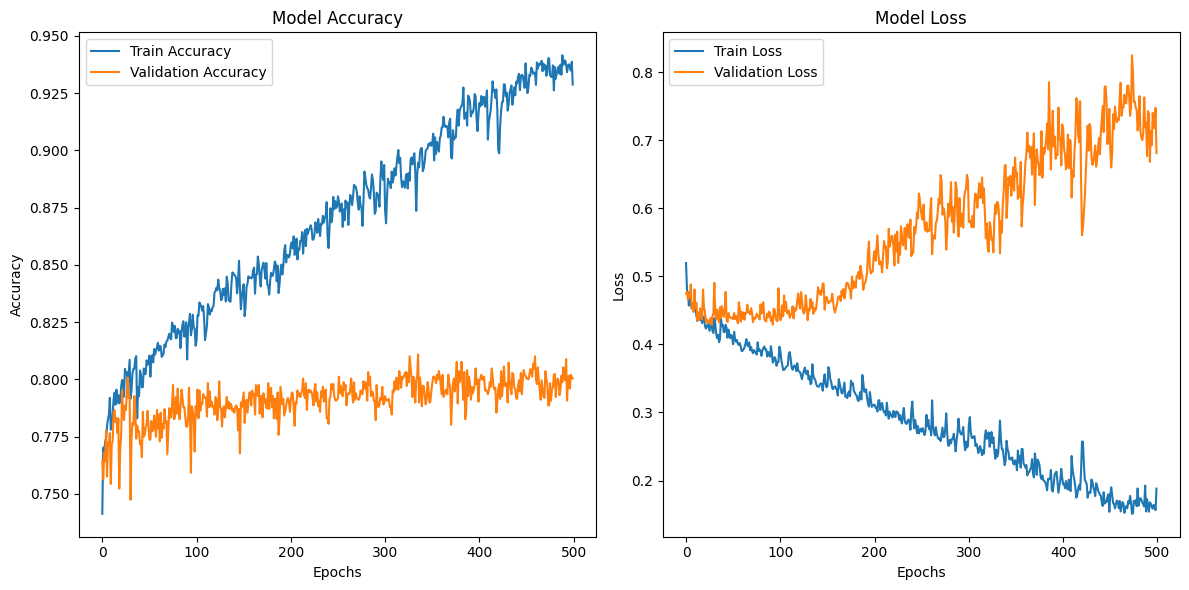

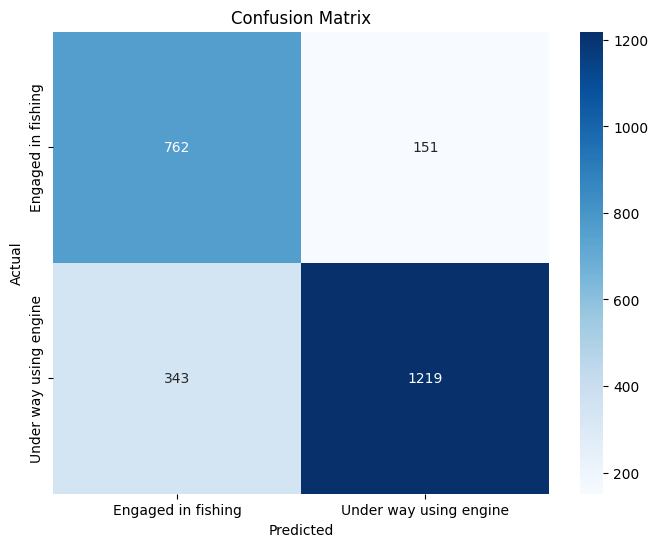

Classification Report:
                        precision    recall  f1-score   support

    Engaged in fishing       0.69      0.83      0.76       913
Under way using engine       0.89      0.78      0.83      1562

              accuracy                           0.80      2475
             macro avg       0.79      0.81      0.79      2475
          weighted avg       0.82      0.80      0.80      2475

Weighted F1-Score: 0.80


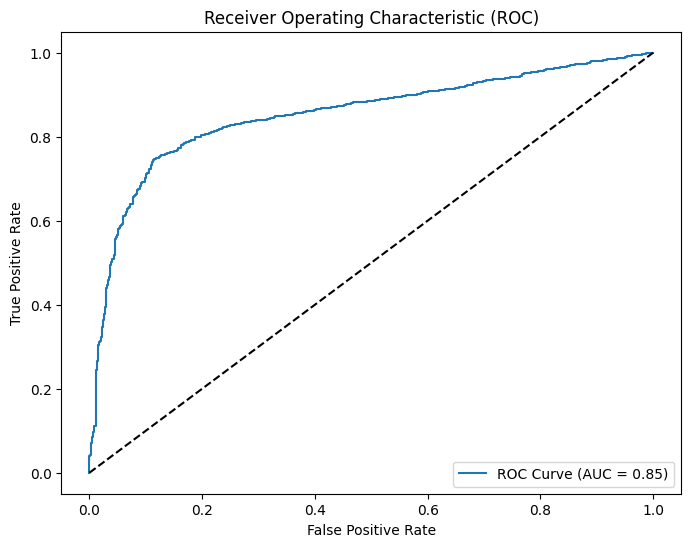

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score
import seaborn as sns
import numpy as np

# Plot the learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Plot learning curve
plot_learning_curve(history)

# Confusion matrix
class_names = label_encoder.classes_
plot_confusion_matrix(y_test_true, y_test_pred, class_names)

# Classification report and F1-score
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

# F1-score
f1 = f1_score(y_test_true, y_test_pred, average='weighted')
print(f"Weighted F1-Score: {f1:.2f}")

# ROC curve
plot_roc_curve(y_test_true, y_test_pred_prob)
